**Calculate historical risk values** using *risk_calculation.py*

In [2]:
# Calculate risk function - same as risk_calculation.py, just this time average_brightness is stored as a variable
import numpy as np
import pandas as pd
import ast
import time
import datetime
import statistics 
from tqdm import tqdm

# function
def calculateDays(date1, date2):
    day1 = time.strptime(date1, "%Y-%m-%d")
    day1 = datetime.datetime(day1[0], day1[1], day1[2])
    day2 = time.strptime(date2, "%Y-%m-%d")
    day2 = datetime.datetime(day2[0], day2[1], day2[2])
    #today = datetime.datetime.today()
    interval = day1 - day2
    return interval.days

# read the cleaned and procesed data
c_df = pd.read_csv('data/combined_dataframes.csv')

# Convert the contents of the pandas array from strings looking like lists to actual lists
brightness_MODIS = c_df.loc[:,'bright_ti4'].apply(ast.literal_eval)
brightness_VIIRS = c_df.loc[:,'bright_ti5'].apply(ast.literal_eval)
instrument = c_df.loc[:,'instrument'].apply(ast.literal_eval)

# Initialise the risk vector
risk = np.zeros(len(c_df.latitude))

for i,list in enumerate(tqdm(iterable = brightness_MODIS, desc = "Insert brightness_MODIS")):
    risk[i] += statistics.mean(list)

for i,list in enumerate(tqdm(iterable = brightness_VIIRS, desc = "Insert brightness_VIIRS")):
    risk[i] += statistics.mean(list)

# Calculate the average of each of the brightnesses
for i,list in enumerate(tqdm(iterable = risk, desc = "Calculate the average")):
    risk[i] = risk[i] / len(instrument[i]) # divide by the number of instruments i.e. mean of 1 or mean of 2
average_brightness = risk.copy()

timeRange = np.zeros(len(c_df.latitude))
timeData = c_df["acq_date"].apply(ast.literal_eval)
for i, value in enumerate(tqdm(iterable = timeData, desc = "Calculate Time Range")):
    # if only one day, the result will be the difference between that and the date today
    if len(value) == 1:
        timeRange[i] = abs(calculateDays("2020-02-15",timeData[i][0]))
    # if more than one day, the result will be the difference between the start day and the end day
    elif len(value) > 1:
        # start day
        date1 = timeData[i][0]
        # end day
        date2 = timeData[i][-1]
        timeRange[i] = abs(calculateDays(date2,date1))
# divided by the time range
for i,list in enumerate(tqdm(iterable = risk, desc = "Generate the final Risk")):
    risk[i] = risk[i] / timeRange[i]

Generate the final Risk: 100%|█████████████████████████████████████████████| 708008/708008 [00:01<00:00, 560301.61it/s]


**Import required packages**

In [3]:
import numpy as np
import pandas as pd

import time
import pandas as pd 
import ast

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from visualisation import generate_map

**Define the imput dataset to the Machine Learning Code from the historical risk values and cleaned data**

In [4]:
dataset = pd.concat([c_df.latitude, c_df.longitude,
                     pd.DataFrame(timeRange, columns=['timeRange']), 
                     pd.DataFrame(average_brightness, columns=['avg_brightness']),
                     pd.DataFrame(risk, columns=['risk'])],
                    axis = 1)
dataset.tail()

,latitude,longitude,timeRange,avg_brightness,risk
708003,-10.16375,142.13250,64.0,629.0,9.828125
708004,-10.16375,142.14375,54.0,636.6,11.788889
708005,-10.16375,142.14750,54.0,611.1,11.316667
708006,-10.09625,142.16250,130.0,605.8,4.660000
708007,-9.39875,142.64625,75.0,657.9,8.772000


In [ ]:
dataset.info()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000211CA773208>,
      dtype=object)

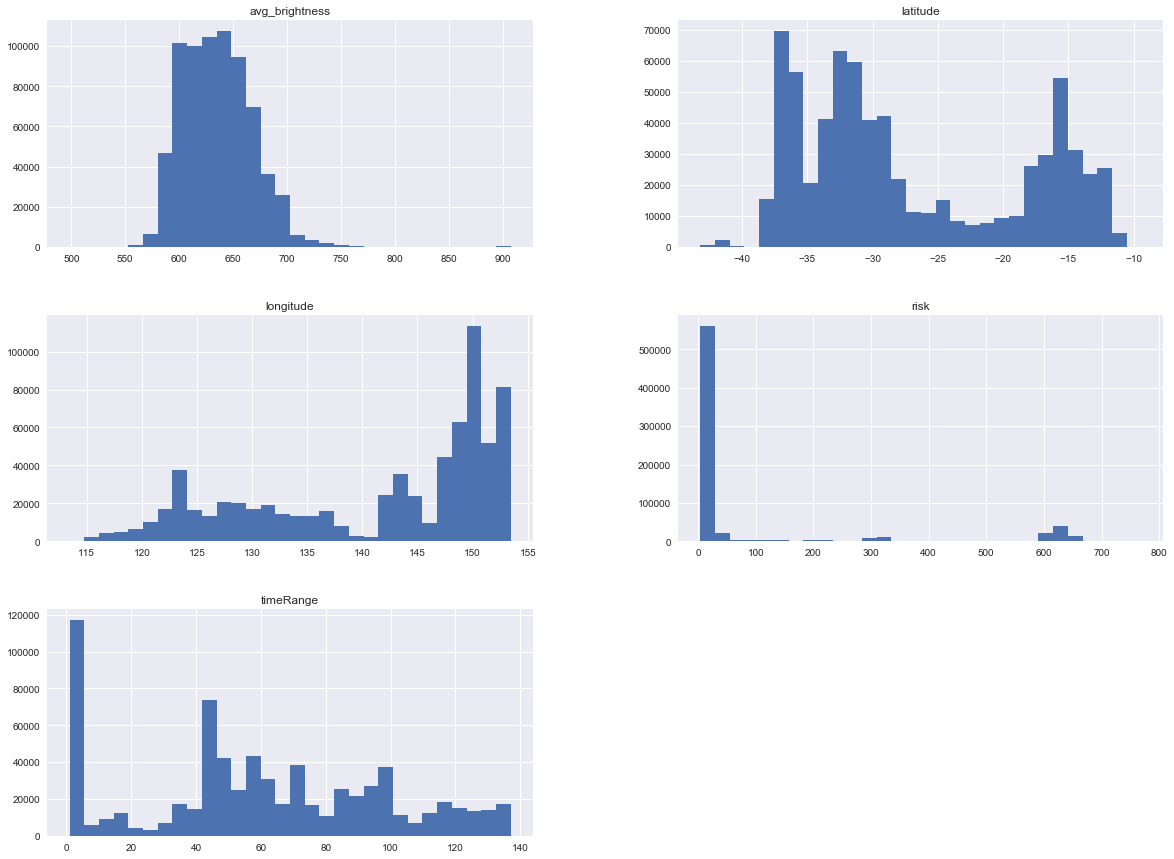

In [6]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
dataset.hist(bins=30, figsize=(20,15))

In [99]:
dataset.corr()

,latitude,longitude,timeRange,avg_brightness,risk
latitude,1.000000,-0.399392,0.471623,0.178046,-0.166792
longitude,-0.399392,1.000000,-0.287636,-0.274887,0.188372
timeRange,0.471623,-0.287636,1.000000,0.138290,-0.653684
avg_brightness,0.178046,-0.274887,0.138290,1.000000,-0.118145
risk,-0.166792,0.188372,-0.653684,-0.118145,1.000000


In [11]:
features = dataset[['latitude', 'longitude', 'timeRange', 'avg_brightness']]
labels = dataset['risk']
mean_values = features.describe().iloc[1, :]

In [12]:
# Set random seed to ensure reproducible runs
RSEED = 50

**Machine Learning Approach 1**

In [13]:
# Split the dataset into train and test sets: 30% of the data is used for training
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = RSEED)

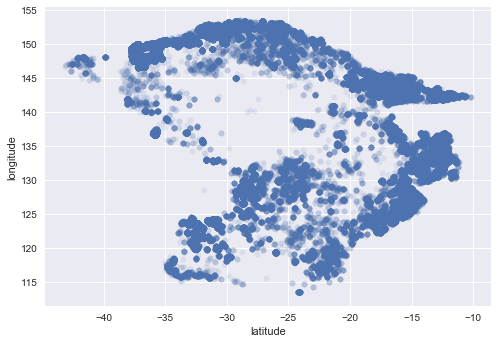

In [28]:
X_test.plot(kind='scatter', x='latitude', y='longitude', alpha=0.1, s=20)

In [ ]:
X_train.plot(kind='scatter', x='latitude', y='longitude', alpha=0.1, s=20)

In [ ]:
X_train.plot(kind='scatter', x='latitude', y='longitude', alpha=0.2, s=20*X_train['avg_brightness'])

In [23]:
corr_matrix = dataset.corr()
corr_matrix['risk'].sort_values(ascending=False)

risk              1.000000
longitude         0.188372
avg_brightness   -0.118145
latitude         -0.166792
timeRange        -0.653684
Name: risk, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000211DA491A88>,
      dtype=object)

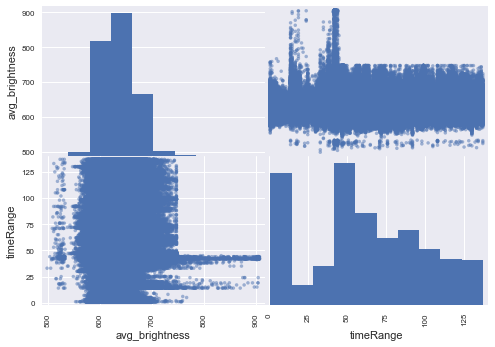

In [31]:
from pandas.plotting import scatter_matrix

attributes = ['avg_brightness', 'timeRange']
scatter_matrix(X_train[attributes], figsize=(15,10))

In [117]:
# train our dataset on the train data and analyse our Mean Absolute Error on the test data.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(verbose=True) # enable a progress bar
clf = RandomForestRegressor(n_estimators = 100, max_depth = 50)
clf.fit(X_train, y_train)
print("Mean Absolute Error: {}".format(mean_squared_error(y_test, clf.predict(X_test))))

Mean Absolute Error: 0.0019263785299654583


In [120]:
# Train the model on the complete dataset and then simply use the post endpoint to get the risk
endpoint_classifier = RandomForestRegressor(n_estimators = 100, max_depth = 50)
endpoint_classifier.fit(fetched_data.data, fetched_data.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

**Machine Learning Approach 2: random forrest**

This takes the idea of a single decision tree, and creates an ensemble model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

In [135]:
labels = np.array(labels)
labels

array([16.63513514, 14.38181818, 14.25227273, ..., 11.31666667,
        4.66      ,  8.772     ])

In [141]:
# Tutorial: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
train, test, train_labels, test_labels = X_train, X_test, y_train, y_test 

In [ ]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(labels)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(features, encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


In [6]:
# We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')